In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from pmdarima.arima import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
from matplotlib.pyplot import figure
import warnings
warnings.simplefilter("ignore")

Using TensorFlow backend.


In [2]:
def get_correlation(item1, item2):
    
    stockdf = pd.read_csv("C:/Users/vaibh/Minor_Project/Stock_Price.csv")
    pd.to_datetime(stockdf['Date'], format='%Y-%m-%d')
    stockdf = stockdf.set_index(pd.DatetimeIndex(stockdf['Date']))
    value_pair = pd.concat([stockdf[item1], stockdf[item2]], axis=1)
    value_pair.columns = [item1, item2]
    correlationdf = value_pair[item1].rolling(window=100).corr(value_pair[item2])
    return correlationdf

def get_corr_matrix(rand_assets):
    
    data = []
    for i in range(len(rand_assets)):
        for j in range(len(rand_assets)-1-i):
            temp1 = rand_assets[i]
            temp2 = rand_assets[9-j]
            series_data = get_correlation(temp1,temp2)[99:]
            stride_data = list(series_data[[100*k for k in range(24)]])
            data.append(stride_data)
    return data
    

In [3]:
ORIGINAL_PORTFOLIO = ['LEG', 'MS', 'IPGP', 'AIG', 'MYL', 'CTXS', 'STT', 'WST', 'UHS', 'UAA', 'CL', 'BKR', 'OMC', 'JBHT', 'CMG', 
             'NOC', 'CMS', 'ALXN', 'REG', 'YUM', 'T', 'AMD', 'KO', 'KR', 'CERN', 'CHD', 'ECL', 'SPG', 'NI', 'INCY', 'SIVB', 
             'GS', 'ROL', 'REGN', 'ODFL', 'SEE','COF', 'WEC', 'ADM', 'CME', 'FCX', 'DLR', 'TRV', 'HBAN', 'CI', 'MSFT', 'OXY', 
             'BLL', 'CHRW','DISCA', 'EXR', 'VRSK', 'MGM', 'SNA', 'BIO', 'STZ', 'AEE', 'ED', 'KSU', 'SLG', 'TFC', 'TMO', 'PCAR',
             'LRCX', 'PPL', 'URI', 'PH', 'CCI', 'MKTX', 'SWKS', 'JPM', 'AEP', 'TEL', 'BDX', 'ATVI', 'CINF', 'RTX', 'CMCSA',
             'HAS','COST', 'CMI', 'DAL', 'HES', 'PG', 'UNP', 'DG', 'GOOGL', 'CF', 'HSY', 'NOV', 'PBCT', 'UNM', 'PEG', 'IP', 
             'AES','INTU', 'DRI', 'LDOS', 'MO', 'KIM', 'HON', 'CB', 'BWA', 'WY', 'AVGO', 'IFF', 'DE', 'MCK', 'BAX', 'TAP', 'GD', 'XRX', 
             'HST', 'NLOK', 'SYY', 'ILMN', 'MAS', 'VAR', 'AVB', 'TIF', 'EIX', 'KMB', 'JNPR', 'SWK', 'AON', 'LB', 'SPGI', 'PXD', 
             'BXP', 'CLX', 'HFC', 'UNH', 'SNPS', 'CNC', 'WYNN', 'IVZ', 'ADI', 'HOLX', 'TT', 'PFE', 'PRGO', 'ARE', 'KMX', 'TDG', 
             'RSG', 'FAST', 'IEX', 'AMZN', 'BBY', 'VNO']
df = pd.read_csv("C:/Users/vaibh/Minor_Project/Stock_Price.csv")
SP500 = list(df.columns.values[1:])
SP500.pop()
selected_companies = list(set(SP500)-set(ORIGNAL_PORTFOLIO))

random.shuffle(selected_companies)
random.seed(1)
rand_assets = selected_companies[:10].copy()
print(rand_assets)

corr_matrix = get_corr_matrix(rand_assets)

processed_data = {}
for i in range(len(corr_matrix)):
    processed_data[str(i)] = corr_matrix[i]
processed_df = pd.DataFrame(processed_data)

pre_arima = []
for i in range(45):
    pre_arima.append(processed_df[str(i)][:21])
    pre_arima.append(processed_df[str(i)][1:22])
    pre_arima.append(processed_df[str(i)][2:23])
    pre_arima.append(processed_df[str(i)][3:])

    
pre_arima = pd.DataFrame(np.array(pre_arima))
pre_arima.to_csv('C:/Users/vaibh/Minor_Project/TEST ASSET/test_asset_before_arima.csv')



['EXPE', 'WBA', 'AXP', 'CHRW', 'JWN', 'AMT', 'ATVI', 'HBI', 'MMC', 'GRMN']


In [4]:
dataset = pd.read_csv('C:/Users/vaibh/Minor_Project/TEST ASSET/test_asset_before_arima.csv')
dataset = dataset.loc[:,~dataset.columns.str.contains('Unnamed')]

#Different models bases on AR I and MA values. Seasonal order adds extra AR I MA regression values.

model_110 = ARIMA(order=(1,1,0), mle_regression=True, suppress_warnings=True)
model_011 = ARIMA(order=(0,1,1), mle_regression=True, suppress_warnings=True)
model_111 = ARIMA(order=(1,1,1), mle_regression=True, suppress_warnings=True)
model_211 = ARIMA(order=(2,1,1), mle_regression=True, suppress_warnings=True)
model_210 = ARIMA(order=(2,1,0), mle_regression=True, suppress_warnings=True)

#Iteratively fit AR, I, MA values for different models. Try/except functionality is used to keep the system going
#even if a single value fails.

flag = 0
c=0
residual = []
for s in np.array(dataset):
    c+=1
    try:
        model1 = model_110.fit(s)
        model = model1

        try:
            model2 = model_011.fit(s)

            if model.aic() <= model2.aic() :
                pass
            else :
                model = model2

            try :
                model3 = model_111.fit(s)
                if model.aic() <= model3.aic() :
                    pass
                else :
                    model = model3
            except :
                try:
                    model4 = model_211.fit(s)

                    if model.aic() <= model4.aic() :
                        pass
                    else:
                        model = model4
                except:
                    try:
                        model5 = model_210.fit(s)

                        if model.aic() <= model5.aic():
                            pass
                        else :
                            model = model5
                    except :
                        pass

        except:
            try:
                model3 = model_111.fit(s)

                if model.aic() <= model3.aic() :
                    pass
                else :
                    model = model3
            except :
                try:
                    model4 = model_211.fit(s)

                    if model.aic() <= model4.aic() :
                        pass
                    else:
                        model = model4
                except:
                    try:
                        model5 = model_210.fit(s)

                        if model.aic() <= model5.aic():
                            pass
                        else :
                            model = model5
                    except :
                        pass

    except:
        try:
            model2 = model_011.fit(s[i])
            model = model2

            try :
                model3 = model_111.fit(s[i])

                if model.aic() <= model3.aic():
                    pass
                else:
                    model = model3
            except :
                try:
                    model4 = model_211.fit(s[i])

                    if model.aic() <= model4.aic() :
                        pass
                    else:
                        model = model4
                except:
                    try:
                        model5 = model_210.fit(s[i])

                        if model.aic() <= model5.aic():
                            pass
                        else :
                            model = model5
                    except :
                        pass

        except :
            try:
                model3 = model_111.fit(s[i])
                model = model3
            except :
                try:
                    model4 = model_211.fit(s[i])

                    if model.aic() <= model4.aic() :
                        pass
                    else:
                        model = model4
                except:
                    try:
                        model5 = model_210.fit(s[i])

                        if model.aic() <= model5.aic():
                            pass
                        else :
                            model = model5
                    except :
                        flag = 1
                        print(str(c) + "Error While fitting ARIMA model. Unable to continue.")
                        break

                        
    predictions = list(model.predict_in_sample())
    predictions = [np.mean(predictions)] + predictions

    res = model.resid()
    residual.append(np.array(res))
    

    if flag == 1:
        break
residual = pd.DataFrame(residual)
residual.to_csv('C:/Users/vaibh/Minor_Project/TEST ASSET/test_asset_after_arima.csv')

180/180 [==============================] - 0s 624us/step
SCORE :
 LOSS - 0.012
 MEAN SQUARED ERROR - 0.012
 MEAN ABSOLUTE ERROR - 0.0503


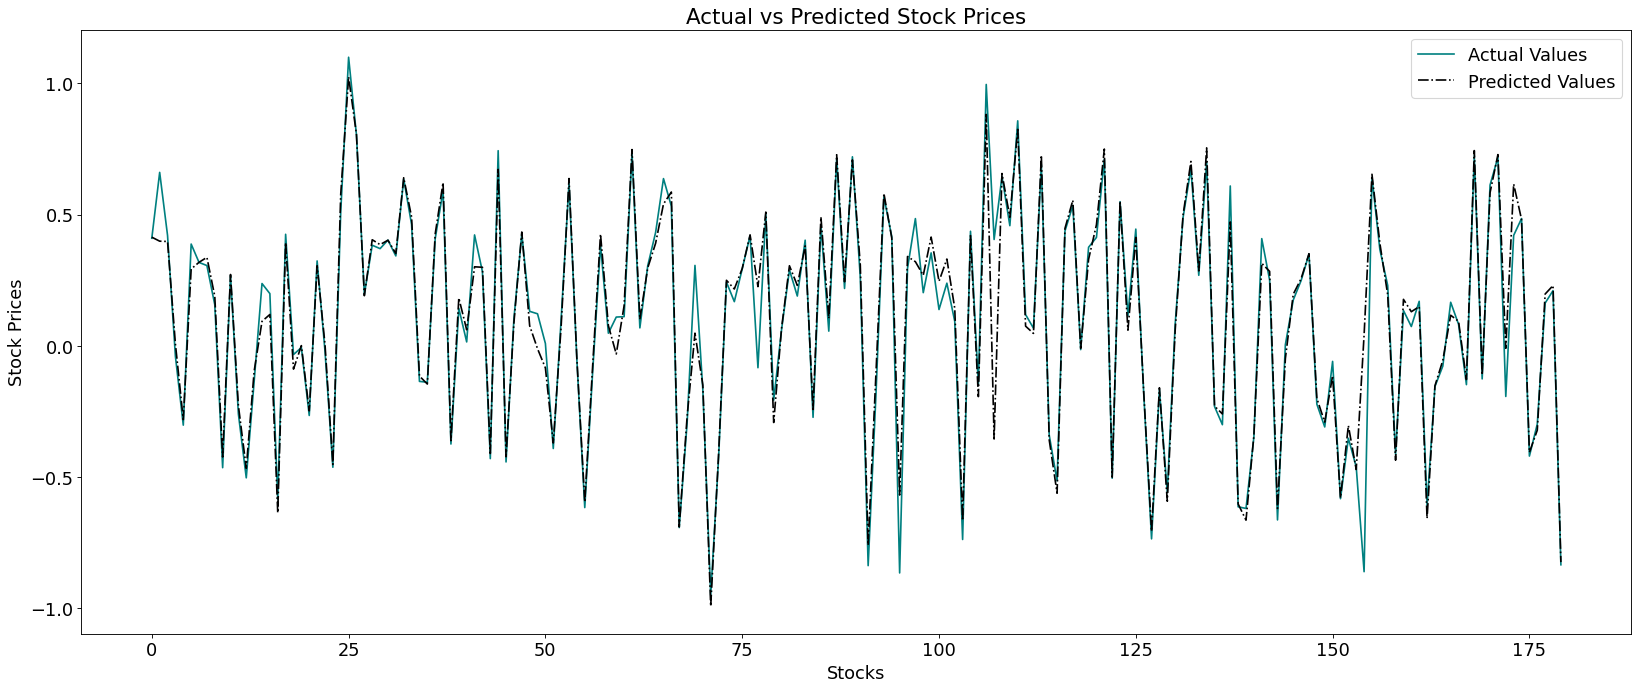

In [5]:
plt.rcParams.update({'font.size': 16})
dataset = pd.read_csv('C:/Users/vaibh/Minor_Project/TEST ASSET/test_asset_after_arima.csv')
dataset = dataset.loc[:,~dataset.columns.str.contains('^Unnamed')]
X = dataset.loc[:,~dataset.columns.str.contains('20')]
Y = dataset.loc[:,dataset.columns.str.contains('20')]

X = np.asarray(X).reshape(180,20,1)
Y = np.asarray(Y).reshape(180,1)


#Activation Function
class Double_Tanh(Activation):
    def __init__(self, activation, **kwargs):
        super(Double_Tanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'

def double_tanh(x):
    return (K.tanh(x) * 2)

get_custom_objects().update({'double_tanh':Double_Tanh(double_tanh)})


#Evaluate model to get predictions/score . 
model = load_model('C:/Users/vaibh/Minor_Project/epochs/epoch258.h5')
score = model.evaluate(X,Y)
print('SCORE :')
print(' LOSS - ' + str(np.round(score[1],4)))
print(' MEAN SQUARED ERROR - ' + str(np.round(score[1],4)))
print(' MEAN ABSOLUTE ERROR - ' + str(np.round(score[2], 4)))

pred = model.predict(np.asarray(X))

#Plot predictions
e1 = Y.flatten()
p1 = pred.flatten()
figure(num=None, figsize=(25, 10), dpi=80, facecolor='w', edgecolor='k')
#plt.scatter(e1, p1, color = "brown", s=5)
plt.plot(e1, color = "teal", label = 'Actual Values')
plt.plot(p1,'-.', color = "black", label = 'Predicted Values')
plt.legend(loc="upper right")
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Stocks")
plt.ylabel("Stock Prices")
plt.show()